Dataset loaded and prepared. First few rows:
          ds        y  total_revenue  net_transaction
0 2022-08-18     0.00         515.00           515.00
1 2022-08-19  3776.02        3852.29            76.27
2 2022-08-20     0.00           0.00             0.00
3 2022-08-21     0.00           0.00             0.00
4 2022-08-22   471.11         380.00           -91.11



16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully.


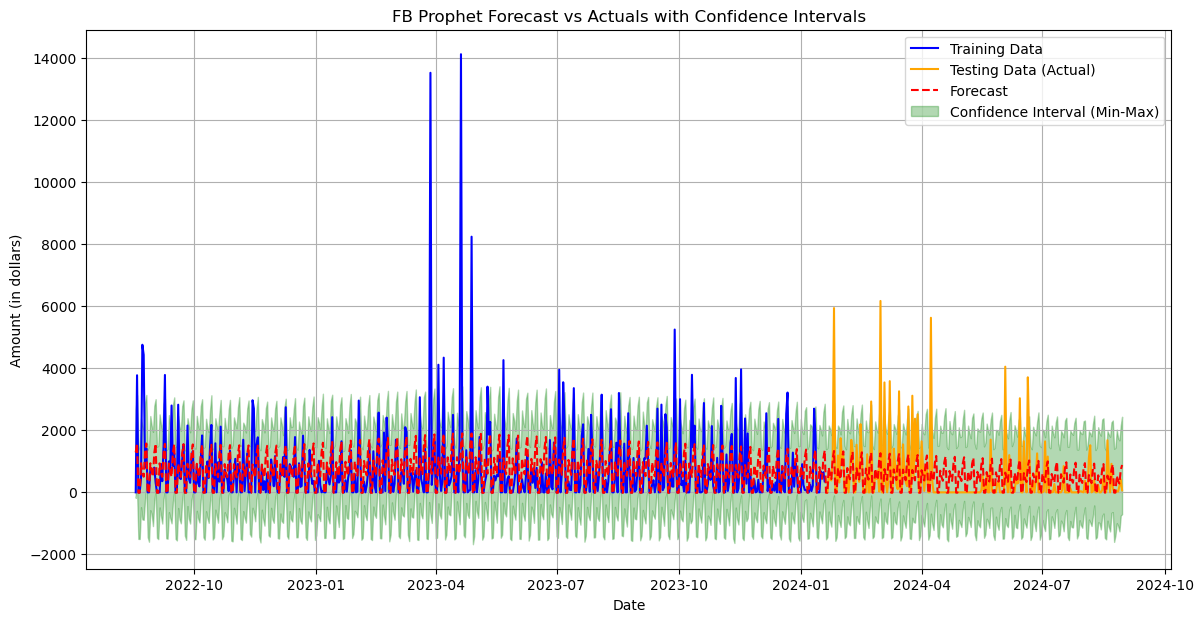

Mean Absolute Error (MAE): 514.08
Mean Squared Error (MSE): 819353.13
Root Mean Squared Error (RMSE): 905.18
Total Forecasted Amount: 111632.24
Forecast results saved to 'Expenses_forecast_Prophet.csv'.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_and_prepare_data(filepath, date_column, target_column):
    """
    Load the dataset, parse dates, and set up the target time series for FB Prophet.
    """
    data = pd.read_csv(filepath)
    data[date_column] = pd.to_datetime(data[date_column])
    data.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
    print(f"Dataset loaded and prepared. First few rows:\n{data.head()}\n")
    return data

def train_fb_prophet(train_data, **prophet_params):
    """
    Train the FB Prophet model on the provided training data.
    """
    model = Prophet(**prophet_params)
    model.fit(train_data)
    print("Model trained successfully.")
    return model

def forecast_with_prophet(model, steps, freq='D'):
    """
    Generate forecasts using the trained Prophet model.
    """
    future = model.make_future_dataframe(periods=steps, freq=freq)
    forecast = model.predict(future)
    return forecast

def plot_forecast_with_confidence(train, test, forecast, title, ylabel):
    """
    Plot the forecast results along with confidence intervals.
    """
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.plot(train['ds'], train['y'], label="Training Data", color="blue")

    # Plot actual test data
    plt.plot(test['ds'], test['y'], label="Testing Data (Actual)", color="orange")

    # Plot forecast
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle="--")

    # Shade the confidence intervals
    plt.fill_between(
        forecast['ds'], 
        forecast['yhat_lower'], 
        forecast['yhat_upper'], 
        color="green", alpha=0.3, label="Confidence Interval (Min-Max)"
    )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_forecast(actual, predicted):
    """
    Evaluate the forecast using MAE, MSE, and RMSE.
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    return mae, mse, rmse

def main(filepath, date_column, target_column, train_ratio=0.7, freq='D', **prophet_params):
    """
    Main pipeline for FB Prophet forecasting.
    """
    # Load and prepare data
    data = load_and_prepare_data(filepath, date_column, target_column)

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    train = data.iloc[:train_size]
    test = data.iloc[train_size:]

    # Train the FB Prophet model
    model = train_fb_prophet(train, **prophet_params)

    # Forecast for the test set
    steps = len(test)
    forecast = forecast_with_prophet(model, steps=steps, freq=freq)

    # Merge forecast with test data for comparison
    forecast_comparison = forecast.merge(test, on='ds', how='right')
    forecast_comparison.rename(columns={'y': 'Actual', 'yhat': 'Predicted', 'yhat_lower': 'Lower_CI', 'yhat_upper': 'Upper_CI'}, inplace=True)

    # Plot the forecast results
    plot_forecast_with_confidence(
        train, 
        test, 
        forecast, 
        title="FB Prophet Forecast vs Actuals with Confidence Intervals",
        ylabel="Amount (in dollars)"
    )

    # Evaluate the forecast
    mae, mse, rmse = evaluate_forecast(forecast_comparison['Actual'], forecast_comparison['Predicted'])

    # Total forecasted amount
    total_forecast = forecast_comparison['Predicted'].sum()
    print(f"Total Forecasted Amount: {total_forecast:.2f}")

    # Save the forecasted results
    output_file = "Expenses_forecast_Prophet.csv"
    forecast_comparison.to_csv(output_file, index=False)
    print(f"Forecast results saved to '{output_file}'.")

# Run the pipeline dynamically
if __name__ == "__main__":
    FILEPATH = r"C:\upi_data\transactions_single_account.csv"
    DATE_COLUMN = "transaction_date"
    TARGET_COLUMN = "total_expenses"
    main(
        filepath=FILEPATH,
        date_column=DATE_COLUMN,
        target_column=TARGET_COLUMN,
        train_ratio=0.7,
        freq='D',  # Frequency: Daily
        seasonality_mode='multiplicative'  # Example Prophet parameter, can be adjusted dynamically
    )




    
